In [1]:
import os
import sys
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)


In [2]:
df = pd.read_csv('data/mturk_experiment_1_results_interspeech2021.csv')
# df = pd.read_csv('data/mturk_experiment_2_results_interspeech2021.csv')


df_tmp = df.groupby(['model', 'snr']).agg({"naturalness": ["count", "mean", "sem"]}).reset_index()
df_tmp['model'].unique()


array(['pretrained_germain', 'unet_A1', 'unet_A123', 'unet_A123W123',
       'unet_A1W1', 'unet_R1', 'unet_R123', 'unet_W1', 'unet_W123',
       'unet_W1T1', 'unet_cochlear_envelopes', 'unet_cochlear_human',
       'unet_germain_deep_features', 'unet_waveform', 'unprocessed_input',
       'wavenet_waveform'], dtype=object)

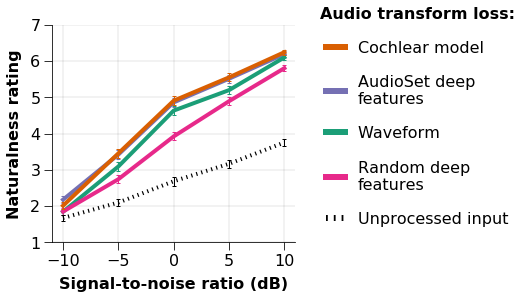

In [14]:
list_model = [
    'unet_cochlear_human',
    'unet_A123',
    'unet_waveform',
    'unet_R123',
    'unprocessed_input',
    
#     'unet_cochlear_human',
#     'unet_cochlear_reverse',
#     'unet_cochlear_linear',
#     'unet_cochlear_human_n05',
#     'unet_cochlear_human_n10',
#     'unet_cochlear_human_n20',
#     'unet_cochlear_human_n80',
    
]

map_kwargs_plot_update = {
    'unet_A123': {'label': 'AudioSet deep\nfeatures', 'color': '#7570b3', 'ls': '-'},
    'unet_R123': {'label': 'Random deep\nfeatures', 'color': '#e7298a', 'ls': '-'},
    'unet_cochlear_human': {'label': 'Cochlear model', 'color': '#d95f02', 'ls': '-', 'zorder':10},
    'unet_waveform': {'label': 'Waveform', 'color': '#1b9e77', 'ls': '-'},
    'unprocessed_input': {'label': 'Unprocessed input', 'color': 'k', 'ls': '--', 'dashes': (0.3, 1)},
}

fig, ax_arr = plt.subplots(figsize=(8,4), nrows=1, ncols=2, gridspec_kw={'width_ratios': [3,2]})
ax = ax_arr[0]

for model in list_model:
    df_tmp_tmp = df_tmp[df_tmp['model'] == model]
    x = df_tmp_tmp['snr'].values
    y = df_tmp_tmp['naturalness']['mean'].values
    yerr = df_tmp_tmp['naturalness']['sem'].values
    kwargs_plot = {
        'yerr': yerr,
        'label': model,
        'lw': 4,
        'elinewidth': 1,
        'capsize': 2,
    }
    kwargs_plot.update(map_kwargs_plot_update.get(model, {}))
    ax.errorbar(x, y, **kwargs_plot)

ax.set_xlim([-11, 11])
ax.set_ylim([1, 7])
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xlabel('Signal-to-noise ratio (dB)', fontsize=16, labelpad=8, fontweight='bold')
ax.set_ylabel('Naturalness rating', fontsize=16, labelpad=8, fontweight='bold')

major_tick_params_kwargs = {
    'axis': 'both',
    'which': 'major',
    'labelsize': 16,
    'length': 8,
    'direction': 'out',
}
ax.tick_params(**major_tick_params_kwargs)
ax.grid(linewidth=0.1, color='k')
for spine_key in ['top', 'right']:
    ax.spines[spine_key].set_visible(False)

for spine_key in ['top', 'right', 'bottom', 'left']:
    ax_arr[1].spines[spine_key].set_visible(False)
ax_arr[1].set_xticks([])
ax_arr[1].set_yticks([])

legend_kwargs = {
    'loc': 'center',
    'borderpad': 0,
    'borderaxespad': 0,
    'handletextpad': 0.8,
    'frameon': False,
    'handlelength': 1.2,
    'markerscale': 1.0,
    'fontsize': 16,
    'labelspacing': 1.2
}

handles, labels = ax.get_legend_handles_labels()
handles = [h[0] for h in handles]
leg = ax_arr[1].legend(handles, labels, **legend_kwargs)
for legobj in leg.legendHandles:
    legobj.set_linewidth(6)

ax_arr[1].set_title('Audio transform loss:', fontsize=16, fontweight='bold')

plt.show()
